In [5]:
import os
from PIL import Image
import cv2

# Visualizing smog

Note: the title of this notebook is a play on Kacey Musgraves' song "Blowing smoke" that happened to be playing when I started this exploration. 

### <font color=blue>What is smog ?<font>

Smog is a mixture of smoke, gases, and chemicals, especially in cities, that makes the atmosphere difficult to breathe and harmful for health (Cambridge dictionary)

### <font color=blue>Smog vs. fog<font>

The representation of smog and fog can seem like similar tasks at first.
Rendering fog has been particularly explored in the context of autonomous vehicles for data augmentation to make models robust to different weather conditions from very simple techniques. 
There are also [camera fog filters](https://www.bhphotovideo.com/c/l-search?q=fog%20filter&N=0), so our baseline will be set with classical image processing. Maybe we could even use some tool in photoshop if it exists! 

One main visual difference is the color: fog usually puts a white veil on objects, while smog can present more variations. 
The physics is also slightly different. 

### <font color=green> The physics<font>

I got lost in looking at the physics of fog, and fog grows vertically. 
<img src="https://blog.metservice.com/sites/default/files/u36/Diagram2_CD_Radiation_Fog.png" alt="drawing" width="600"/>
Smog however is formed when atmospheric pollutants or gases released in the air react with sunlight and its heat in the atmosphere. 
In the literature however, it didn't seem like the physics of it was really a priority...

### <font color=green> Existing work and baseline<font>

#### <font color=orange> Basic image processing <font> 
Why do complicated when it could be simple? 
We try simply blurring the image as in the approach proposed [here](https://www.freecodecamp.org/news/image-augmentation-make-it-rain-make-it-snow-how-to-modify-a-photo-with-machine-learning-163c0cb3843f/) (but their implementation led to weird pink contours on our images so we just use the blur function from opencv).


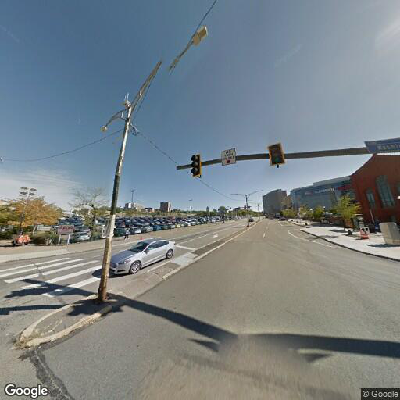

In [47]:
Image.open('./sample_data/gsv_000294.jpg').resize((400,400))

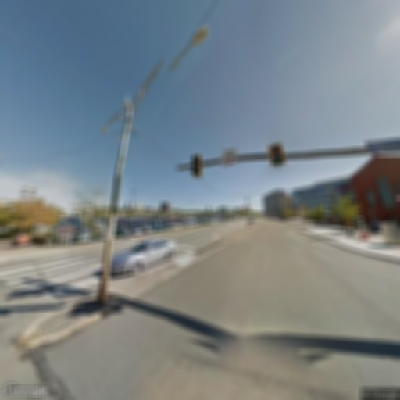

In [35]:
image = cv2.blur(cv2.imread('./sample_data/gsv_000294.jpg'), (10,10), cv2.BORDER_DEFAULT)  
Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)).resize((400,400))

We not there quite yet with simple blur ... 


#### <font color=orange> Realistic fog <font>
The team behind https://github.com/noahzn/FoHIS has done a great job at adding fog to images. 
They also highlight the lack of consideration for the physics of fog phenomena. They managed to get realistic rendering of fog with the right tuning of fog parameters such as height of haze and fog, and by considering the geometry of the scene, using depth maps and camera parameters.             


For our street view images, we do not have ground truth depth maps, so we rely on depth maps computed with MegaDepth. 
The only drawback of this approach is that we have to tune the parameters manually, and after a bit of fumbling, I found a set of parameters that wouldn't draw a big delimitation line at the bottom of the foggy area (which made
 things look very unrealistic). 
 
<img src="./sample_data/gsv_FoHIS.jfif" alt="drawing" width="600"/>

But somehow, the fog appeared in a hue of blue (in the images from the researchers' dataset, it was more white) which is not that common in images of smog - usually depicted in the media in a hue of brown or orange. That sometimes led to the pictures looking like there were water fountains and not really fog...
    <img src="./sample_data/foHIS.JPG" alt="drawing" width="400"/>
We put an orange filter - literally overlayed a transparent layer of orange - to make our baseline. 
<img src="./sample_data/foHISoverlay.JPG" alt="drawing" width="400"/>

So we are not quite there yet... But before moving onto the GAN approach, what do people outside the ML community say when it comes to adding fog to an image? 

### Can we outperform a Photoshop noob ?

What if we just have some good fog images and overlay them ? I followed https://medialoot.com/blog/how-to-add-easy-fog-overlays-to-any-image/ (except in Python) and here's what I got:

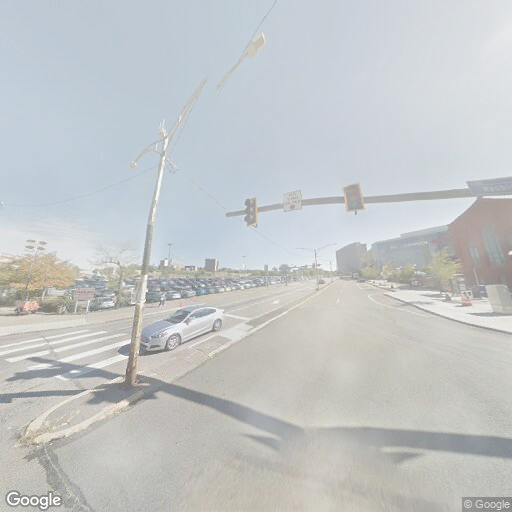

In [169]:
blended = Image.blend(Image.open('./sample_data/gsv_000294.jpg').convert('RGBA'),Image.open('./sample_data/fog01.png').crop((10,0,522,512)), alpha=0.4)
blended

In [170]:
im = Image.open('./sample_data/fog01.png')

In [173]:
arr = np.array(Image.open('./sample_data/fog01.png').crop((10,0,522,512)))
arr[:,:,1] = 216
arr[:,:,2] = 177

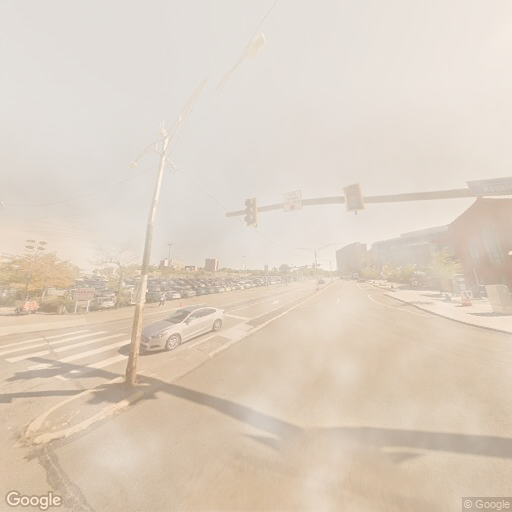

In [175]:
blended = Image.blend(Image.open('./sample_data/gsv_000294.jpg').convert('RGBA'),Image.fromarray(arr), alpha=0.6)
blended

Actually not too bad eh !

## SmoGAN

Let's try a GAN approach to adding fog!